In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
from os import listdir
from os.path import exists

In [2]:
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
import cv2

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Récupération des données

In [5]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [6]:
data = pd.read_csv(path_csv)

## Visualisation du dataset

In [7]:
data.describe(include='all').T

count unique   
uniq_id                    1050   1050  \
crawl_timestamp            1050    149   
product_url                1050   1050   
product_name               1050   1050   
product_category_tree      1050    642   
pid                        1050   1050   
retail_price             1049.0    NaN   
discounted_price         1049.0    NaN   
image                      1050   1050   
is_FK_Advantage_product    1050      2   
description                1050   1050   
product_rating             1050     27   
overall_rating             1050     27   
brand                       712    490   
product_specifications     1049    984   

                                                                       top   
uniq_id                                   55b85ea15a1536d46b7190ad6fff8ce7  \
crawl_timestamp                                  2015-12-01 12:40:44 +0000   
product_url              http://www.flipkart.com/elegance-polyester-mul...   
product_name             Elegance Polyester Multicolor Abstract Eyelet ...   
product_category_tree    ["Home Furnishing >> Bed Linen >> Blankets, Qu...   
pid                                                       CRNEG7BKMFFYHQ8Z   
retail_price                                                           NaN   
discounted_price                                                       NaN   
image                                 55b85ea15a1536d46b7190ad6fff8ce7.jpg   
is_FK_Advantage_product                                              False   
description              Key Features of Elegance Polyester Multicolor ...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                         PRINT SHAPES   
product_specifications   {"product_specification"=>[{"key"=>"Type", "va...   

                        freq         mean          std   min    25%    50%   
uniq_id                    1          NaN          NaN   NaN    NaN    NaN  \
crawl_timestamp          150          NaN          NaN   NaN    NaN    NaN   
product_url                1          NaN          NaN   NaN    NaN    NaN   
product_name               1          NaN          NaN   NaN    NaN    NaN   
product_category_tree     56          NaN          NaN   NaN    NaN    NaN   
pid                        1          NaN          NaN   NaN    NaN    NaN   
retail_price             NaN  2186.197331  7639.229411  35.0  555.0  999.0   
discounted_price         NaN  1584.527169   7475.09968  35.0  340.0  600.0   
image                      1          NaN          NaN   NaN    NaN    NaN   
is_FK_Advantage_product  993          NaN          NaN   NaN    NaN    NaN   
description                1          NaN          NaN   NaN    NaN    NaN   
product_rating           889          NaN          NaN   NaN    NaN    NaN   
overall_rating           889          NaN          NaN   NaN    NaN    NaN   
brand                     11          NaN          NaN   NaN    NaN    NaN   
product_specifications    22          NaN          NaN   NaN    NaN    NaN   

                            75%       max  
uniq_id                     NaN       NaN  
crawl_timestamp             NaN       NaN  
product_url                 NaN       NaN  
product_name                NaN       NaN  
product_category_tree       NaN       NaN  
pid                         NaN       NaN  
retail_price             1999.0  201000.0  
discounted_price         1199.0  201000.0  
image                       NaN       NaN  
is_FK_Advantage_product     NaN       NaN  
description                 NaN       NaN  
product_rating              NaN       NaN  
overall_rating              NaN       NaN  
brand                       NaN       NaN  
product_specifications      NaN       NaN

In [8]:
@interact
def show_data(key=data.columns):
    return data[key]

interactive(children=(Dropdown(description='key', options=('uniq_id', 'crawl_timestamp', 'product_url', 'produ…

In [9]:
# Visualisation feature par feature des NaN et catégories
data_summary = pd.DataFrame(
    {},
)


data_tmp = pd.DataFrame(
    {},
)
data_tmp["feature"] = data.columns
data_tmp["qtd_null"] = data.isnull().sum().values
data_tmp["%_null"] = (100 * data.isnull().sum() / data.shape[0]).values
data_tmp["dtype"] = data.dtypes.values
data_tmp["qtd_cat"] = [
    n if t == "object" else 0 for n, t in zip(data.nunique(), data.dtypes)
]

data_summary = pd.concat([data_summary, data_tmp], ignore_index=True)

data_summary.style.background_gradient(cmap="YlGnBu", axis=0)

Valeurs extrèmes des prix

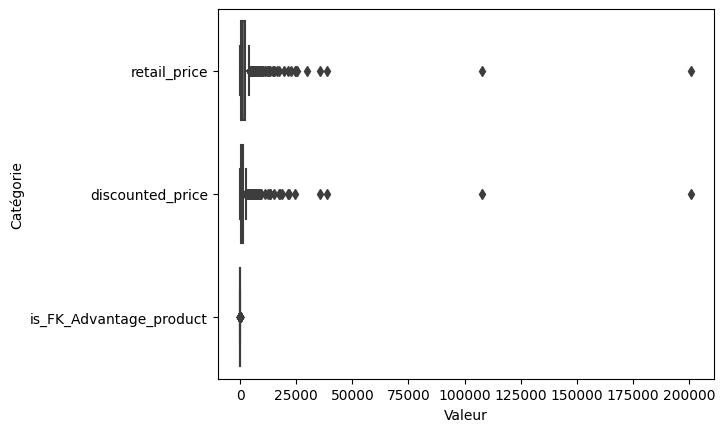

In [10]:
ax = sns.boxplot(data=data, orient="h")
ax.set(xlabel="Valeur", ylabel="Catégorie")

plt.show()

## Visualisation des images
Premiers tests et mise en place des fonctions utiles

In [11]:
from IPython.display import display, HTML

In [12]:
# Affichage de plusieurs images en même temps
def show_from_cv2_multi(images, titles):
    fig = plt.figure(figsize=(16, 16))
    cols = 2
    rows = len(images) // cols + 1
    for i, img in enumerate(images):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            plt.title(titles[i])
    
    plt.show()

In [13]:
# Affichage d'une seule image
def show_from_cv2(img):
    plt.figure(figsize=(7, 7))
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return plt.show()

In [14]:
print("Liste des ID d'image non ratachés à une image existante :")
for name in data['image']:
    if not exists(path_img+'/'+name):
        print(uniq_id)

Liste des ID d'image non ratachés à une image existante :


In [15]:
def path_to_image_html(name):
    return '<img src="'+ path_img + '/' + name + '" width="60" >'

display(HTML(data[['uniq_id', 'product_name', 'image']].head(11).to_html(escape=False ,formatters={'image':path_to_image_html}, col_space=2)))

In [16]:
@interact
def show_img(key=data.index):
    img = cv2.imread(path_img+'/'+data.loc[key, 'image'])
    return show_from_cv2(img)

interactive(children=(Dropdown(description='key', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

# Analyse préliminaire pour ORB

## Visualisation du traitement d'une image

In [17]:
id_ligne = 10
id_ligne = 0

In [18]:
ligne = data.iloc[id_ligne]

In [19]:
ligne

uniq_id                                     55b85ea15a1536d46b7190ad6fff8ce7
crawl_timestamp                                    2016-04-30 03:22:56 +0000
product_url                http://www.flipkart.com/elegance-polyester-mul...
product_name               Elegance Polyester Multicolor Abstract Eyelet ...
product_category_tree      ["Home Furnishing >> Curtains & Accessories >>...
pid                                                         CRNEG7BKMFFYHQ8Z
retail_price                                                          1899.0
discounted_price                                                       899.0
image                                   55b85ea15a1536d46b7190ad6fff8ce7.jpg
is_FK_Advantage_product                                                False
description                Key Features of Elegance Polyester Multicolor ...
product_rating                                           No rating available
overall_rating                                           No rating available

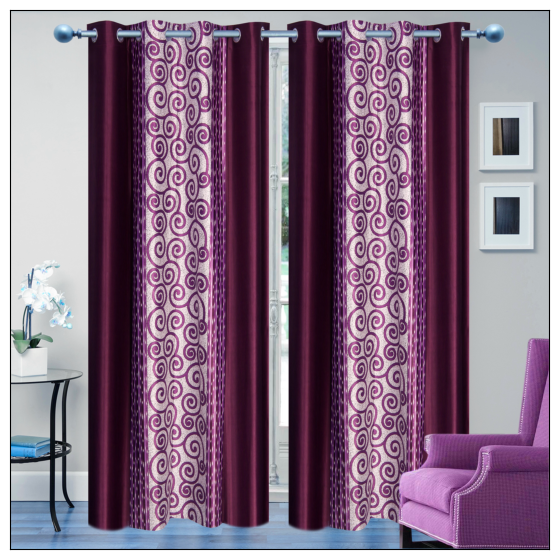

In [20]:
img = cv2.imread(path_img+'/'+ligne['image'])
show_from_cv2(img)

In [21]:
print("Taille de la matrice de pixels : {}".format(img.shape))

Taille de la matrice de pixels : (3600, 3600, 3)


Chargement de la version noir et blanc

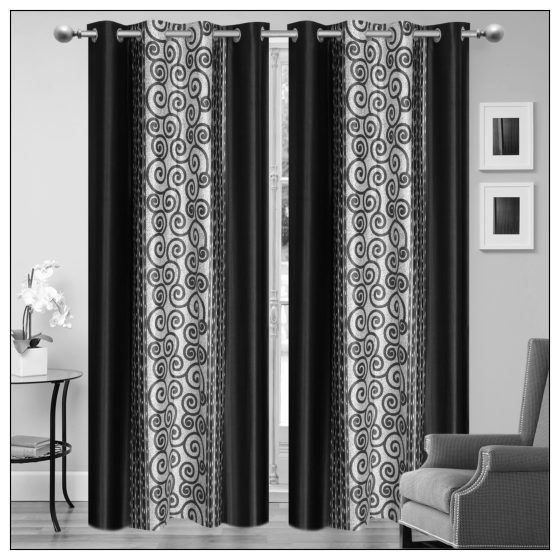

In [22]:
img = cv2.imread(path_img+'/'+ligne['image'], cv2.IMREAD_GRAYSCALE)
show_from_cv2(img)

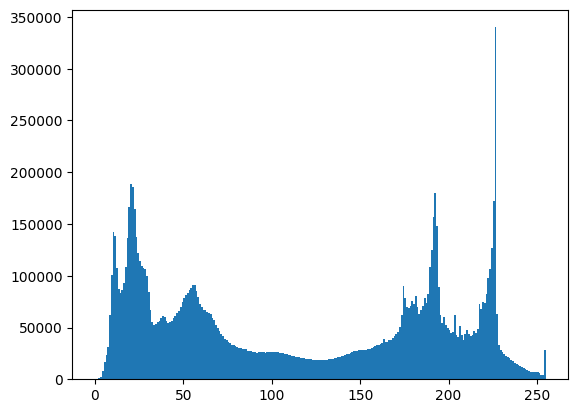

In [23]:
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

Egalisation de l'image

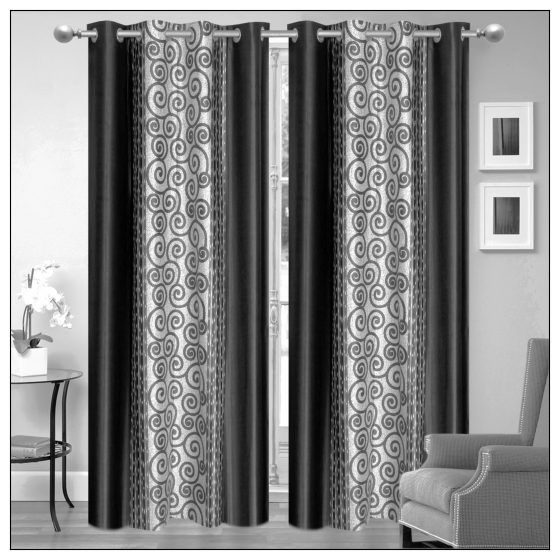

In [24]:
img_tmp = cv2.equalizeHist(img)
show_from_cv2(img_tmp)

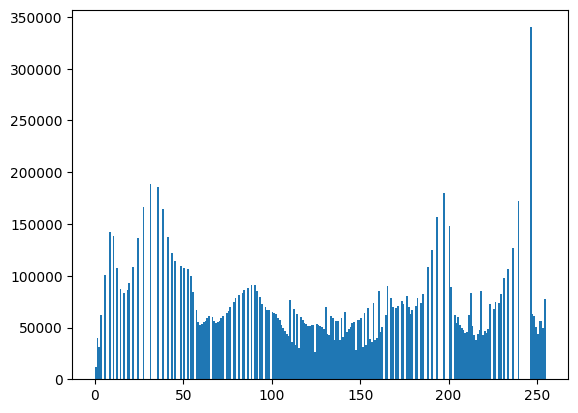

In [25]:
n, bins, patches = plt.hist(img_tmp.flatten(), bins=range(256))
plt.show()

Normalisation de l'image

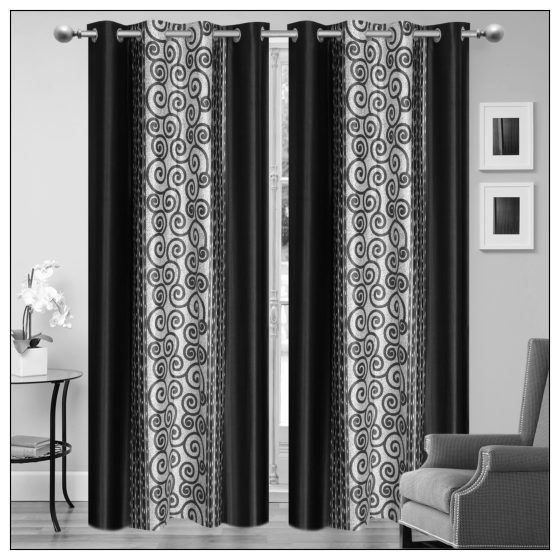

In [26]:
img_tmp = cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
show_from_cv2(img_tmp)

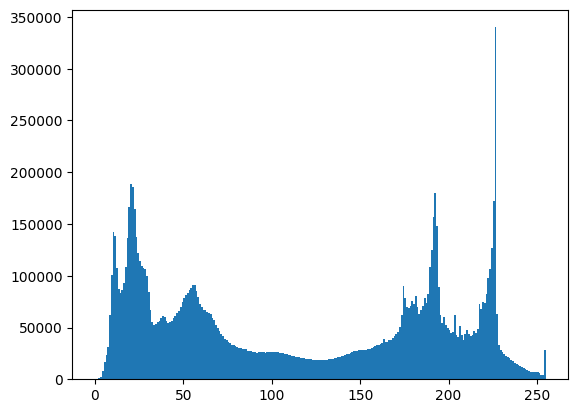

In [27]:
n, bins, patches = plt.hist(img_tmp.flatten(), bins=range(256))
plt.show()

Test d'ajout de flou

In [28]:
taille_filtre = 15

In [29]:
img = cv2.imread(path_img+'/'+ligne['image'], cv2.IMREAD_GRAYSCALE)
print(img.shape)
img = cv2.resize(img, (1000, 1000), interpolation= cv2.INTER_LINEAR)

(3600, 3600)


In [30]:
liste_test_img = []

In [31]:
liste_test_img.append(img)

In [32]:
liste_test_img.append(cv2.blur(img, (taille_filtre, taille_filtre)))

In [33]:
liste_test_img.append(cv2.GaussianBlur(img, (taille_filtre, taille_filtre), 0))

In [34]:
liste_test_img.append(cv2.medianBlur(img, taille_filtre))

In [35]:
liste_test_titles = ['Image de base', 'Flou classique', 'Flou Gaussien', 'Flou Médian']

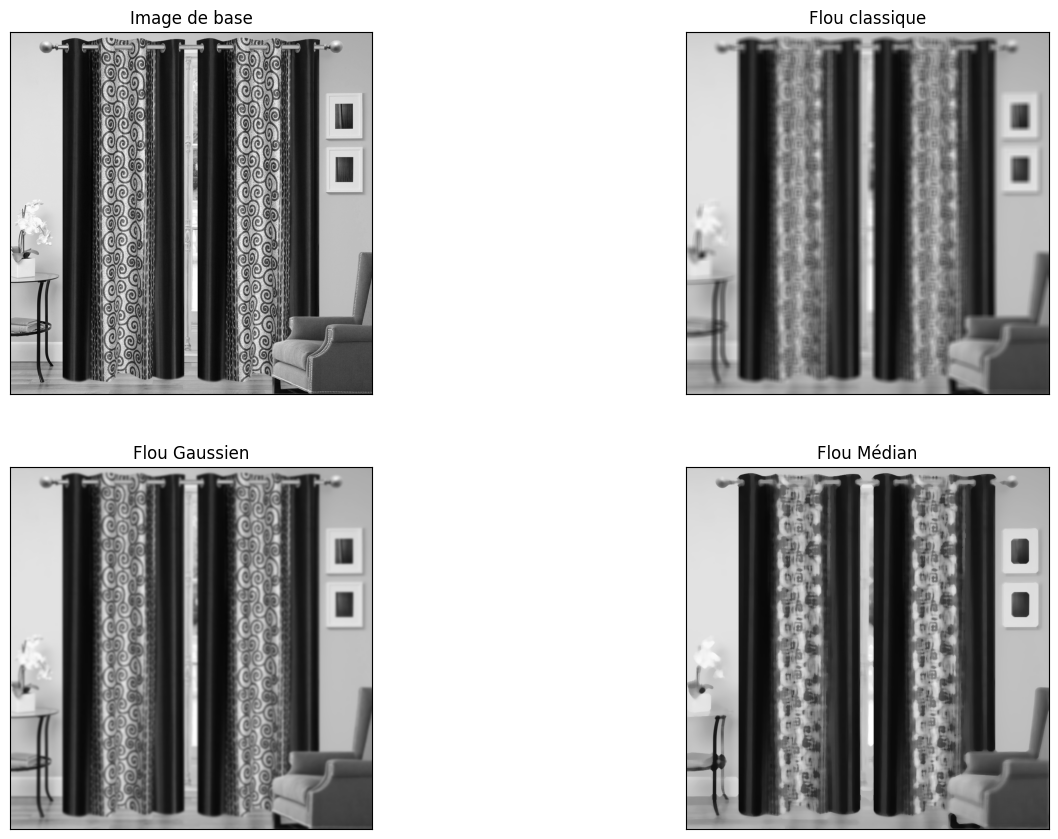

In [36]:
show_from_cv2_multi(liste_test_img, liste_test_titles)

## Visualisation d'une analyse ORB

In [37]:
nb_features = 256

In [38]:
img_tmp = cv2.equalizeHist(img)

In [39]:
orb = cv2.ORB_create(nfeatures=nb_features)

In [40]:
keypoints_orb, descriptors = orb.detectAndCompute(img_tmp, None)

In [41]:
img_keypoint = cv2.drawKeypoints(img, keypoints_orb, 0, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

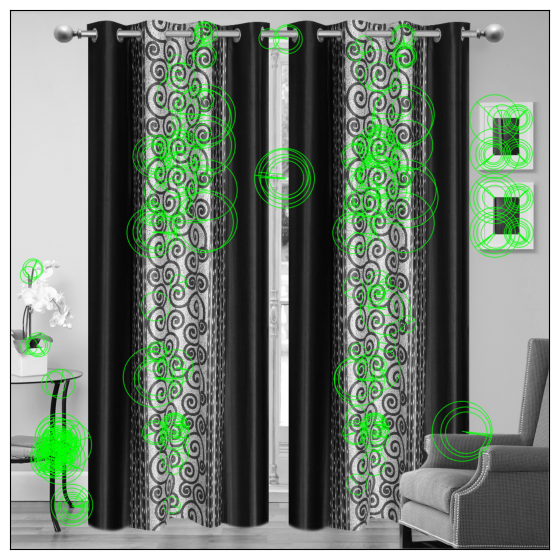

In [42]:
show_from_cv2(img_keypoint)

Comparaison avec les version floutés

In [43]:
liste_ORB = []
for img_tmp in liste_test_img:
    orb = cv2.ORB_create(nfeatures=50)
    keypoints_orb, descriptors = orb.detectAndCompute(img_tmp, None)
    img_keypoint = cv2.drawKeypoints(img_tmp, keypoints_orb, 0, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    liste_ORB.append(img_keypoint)

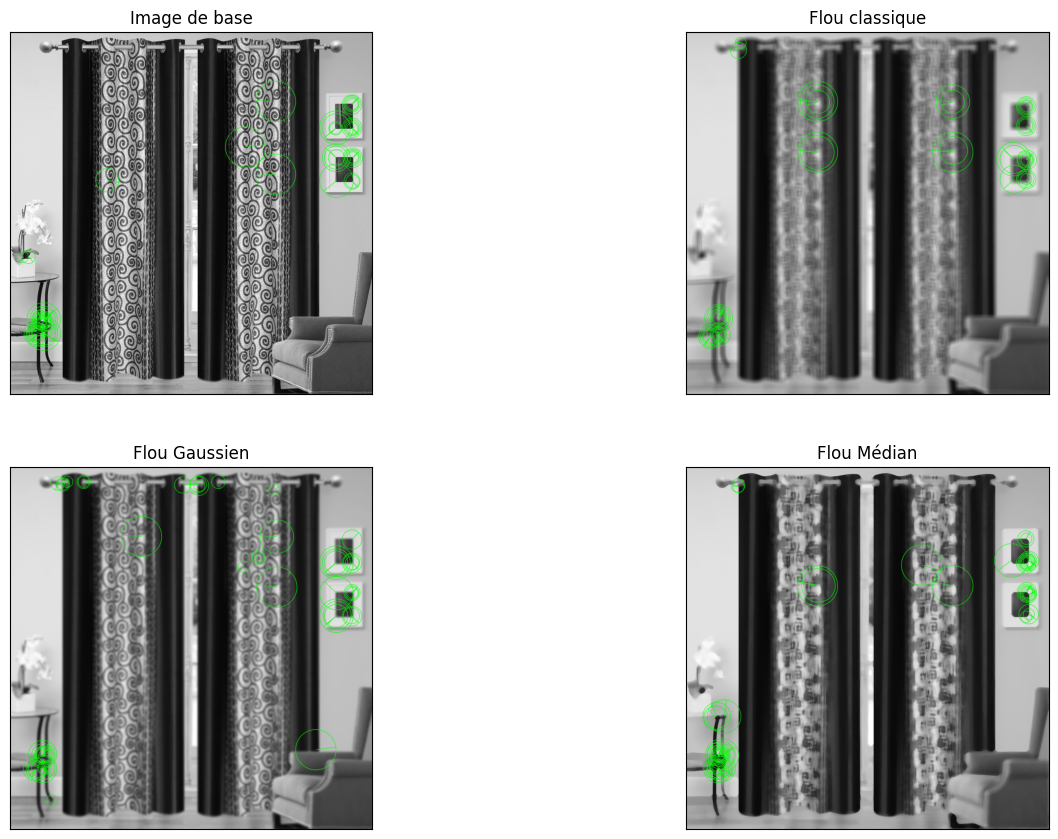

In [44]:
show_from_cv2_multi(liste_ORB, liste_test_titles)

In [45]:
tmp_size = int(0.01 * min(img_tmp.shape) / 2) * 2 + 1

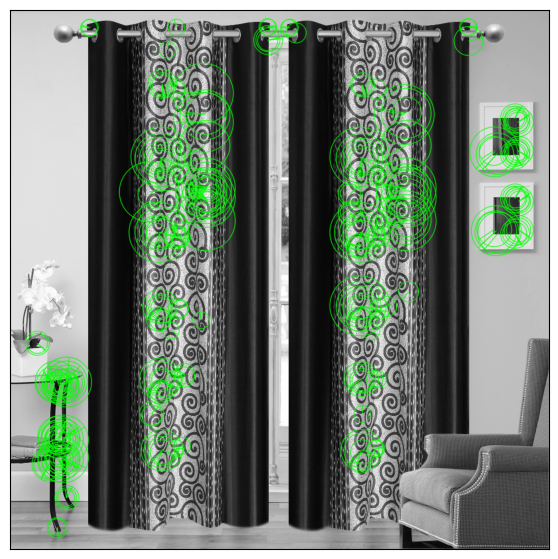

In [46]:
orb = cv2.ORB_create(nfeatures=nb_features)
keypoints_orb, descriptors = orb.detectAndCompute(cv2.GaussianBlur(img_tmp, (tmp_size, tmp_size), 0), None)
img_keypoint = cv2.drawKeypoints(img, keypoints_orb, 0, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_from_cv2(img_keypoint)

# Classification

In [47]:
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

## Reformatage du dataset

Transformation de l'arbre en liste et extraction de sa catégorie la plus générale

In [48]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [49]:
data['category'] = data['product_category_list'].apply(lambda l : l[0])

On ne garde que les colonnes utiles pour nous

In [50]:
data_little = data[['image', 'product_category_list', 'category']].copy()

In [51]:
data_little.columns = ['img', 'cat_lst', 'cat']

In [52]:
data_little['img'] = path_img+'/'+data_little['img']

In [53]:
data_little['cat'].value_counts()

cat
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [54]:
list_labels = list(data_little['cat'].value_counts().index)

In [55]:
nb_cat = len(list_labels)

In [56]:
data_little['label'] = data_little['cat'].apply(lambda e : list_labels.index(e))

In [57]:
data_little

img   
0     ./data/Flipkart/Images/55b85ea15a1536d46b7190a...  \
1     ./data/Flipkart/Images/7b72c92c2f6c40268628ec5...   
2     ./data/Flipkart/Images/64d5d4a258243731dc7bbb1...   
3     ./data/Flipkart/Images/d4684dcdc759dd9cdf41504...   
4     ./data/Flipkart/Images/6325b6870c54cd47be6ebfb...   
...                                                 ...   
1045  ./data/Flipkart/Images/958f54f4c46b53c8a0a9b81...   
1046  ./data/Flipkart/Images/fd6cbcc22efb6b761bd564c...   
1047  ./data/Flipkart/Images/5912e037d12774bb73a2048...   
1048  ./data/Flipkart/Images/c3edc504d1b4f0ba6224fa5...   
1049  ./data/Flipkart/Images/f2f027ad6a6df617c9f1251...   

                                                cat_lst              cat   
0     [Home Furnishing, Curtains & Accessories, Curt...  Home Furnishing  \
1     [Baby Care, Baby Bath & Skin, Baby Bath Towels...        Baby Care   
2     [Baby Care, Baby Bath & Skin, Baby Bath Towels...        Baby Care   
3     [Home Furnishing, Bed Linen, Bedsheets, SANTOS...  Home Furnishing   
4     [Home Furnishing, Bed Linen, Bedsheets, Jaipur...  Home Furnishing   
...                                                 ...              ...   
1045  [Baby Care, Baby & Kids Gifts, Stickers, Oren ...        Baby Care   
1046  [Baby Care, Baby & Kids Gifts, Stickers, Wallm...        Baby Care   
1047  [Baby Care, Baby & Kids Gifts, Stickers, Uberl...        Baby Care   
1048  [Baby Care, Baby & Kids Gifts, Stickers, Wallm...        Baby Care   
1049  [Baby Care, Baby & Kids Gifts, Stickers, Uberl...        Baby Care   

      label  
0         0  
1         1  
2         1  
3         0  
4         0  
...     ...  
1045      1  
1046      1  
1047      1  
1048      1  
1049      1  

[1050 rows x 4 columns]

In [58]:
nb_cat_viz = 5
nb_img_viz = 5

Home Furnishing


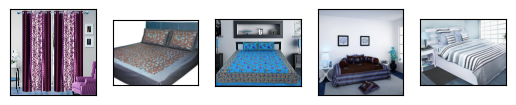

Baby Care


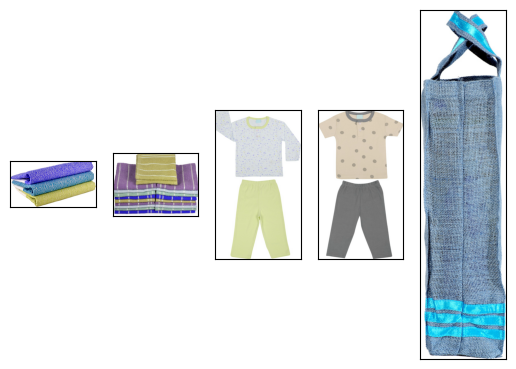

Watches


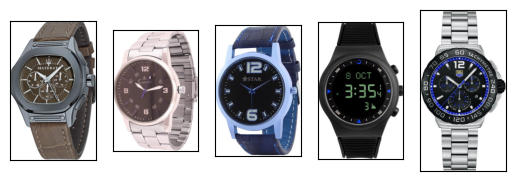

Home Decor & Festive Needs


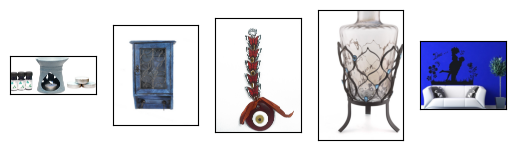

Kitchen & Dining


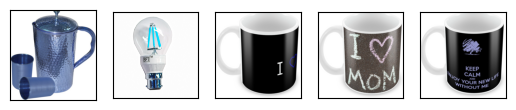

In [59]:
for name in data_little['cat'].unique()[:nb_cat_viz]:
    print(name)
    tmp = list(data_little.loc[data_little['cat']==name, 'img'])
    # print("-------")
    for i in range(nb_img_viz):
        plt.subplot(100 + 1 + i + nb_img_viz*10)
        filename = tmp[i%len(tmp)]
        image = cv2.imread(filename)
        
        
        #cacher axes
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        plt.imshow(image)
    plt.show()

# ORB

In [60]:
nb_features = 256

Chargement des images

In [61]:
image_array = []
for path in data_little['img']:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    blur_size = int(0.01 * min(img.shape) / 2) * 2 + 1
    img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
    
    img = cv2.equalizeHist(img)
    
    image_array.append(img)

Extraction des descipteurs

In [62]:
orb = cv2.ORB_create(nfeatures=nb_features)
descriptors = []
for img in image_array:
    kp, des = orb.detectAndCompute(img, None)
    descriptors.append(des)

In [63]:
descriptors_concat = np.concatenate(descriptors, axis=0)

### Version classique

Création des catégories de descripteurs

In [64]:
# On prépare un certain nombre de catégories
nb_clusters_cat = int(np.sqrt(len(descriptors_concat)))

In [65]:
# On entraine un KMean dessus
kmeans = KMeans(n_clusters=nb_clusters_cat, n_init='auto').fit(descriptors_concat)

Création des vecteurs représentant chaque image

In [66]:
histograms = []
# Pour chaque ensemble de descripteurs
# (représentant une image)
for des in descriptors:
    # On trouve le cluster de ces descripteurs
    cluster_indices = kmeans.predict(des)
    # On fait l'histograme
    histogram, _ = np.histogram(cluster_indices, bins=range(nb_clusters_cat+1), density=True)
    # Et on l'ajoute à notre liste
    histograms.append(histogram)
histograms = np.vstack(histograms)

Clustering final des images

In [67]:
predict_ORB = KMeans(n_clusters=nb_cat, n_init='auto').fit_predict(histograms)

In [68]:
predict_ORB = pd.Series(predict_ORB)

### Version avec moins d'étapes

Prédiction directe des catégories depuis les descripteurs (pas d'histogramme)

In [69]:
kmeans = KMeans(n_clusters=nb_cat, n_init='auto').fit(descriptors_concat)

In [70]:
predict_ORB_short = []

for des in descriptors:
    cluster_indices = kmeans.predict(des)
    histogram, _ = np.histogram(cluster_indices, bins=range(nb_cat+1), density=True)
    predict_ORB_short.append(np.argmax(histogram))

In [71]:
predict_ORB_short = pd.Series(predict_ORB_short)

### Quelques visualisations

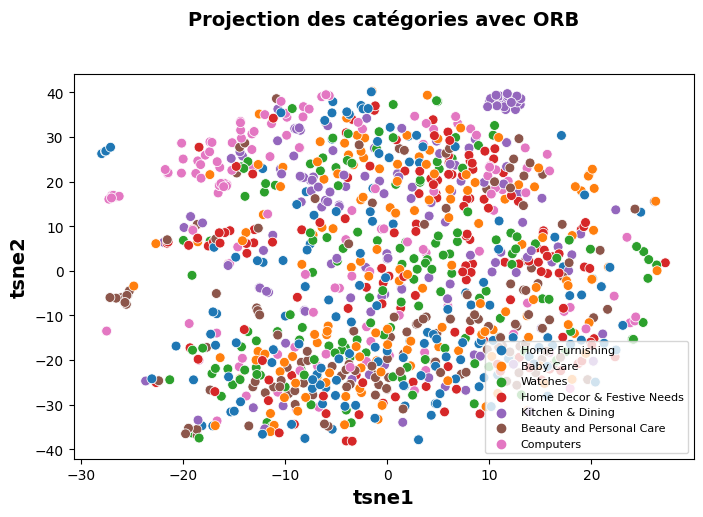

In [72]:
show_representation(histograms, data_little['cat'],
                    title='Projection des catégories avec ORB')
pass

In [73]:
proj_ORB_original = np.copy(histograms)

In [74]:
print("ARI pour ORB :",
      adjusted_rand_score(data_little['label'], predict_ORB))

ARI pour ORB : 0.02970296417628508


In [75]:
print("ARI pour ORB sans histogramme :",
      adjusted_rand_score(predict_ORB_short, data_little['label']))

ARI pour ORB sans histogramme : 0.02421510008711495


In [76]:
print("ARI entre les deux méthodes :", 
      adjusted_rand_score(predict_ORB_short, predict_ORB))

ARI entre les deux méthodes : 0.2797211480505058


# CNN

In [77]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

In [78]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [79]:
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg16 import preprocess_input

Chargement du modele

In [80]:
base_model = DenseNet121()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

Chargement et transformation des images

In [81]:
input_shape = base_model.input_shape

In [82]:
images_features = []
i=0 
for path in data_little["img"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos', keep_aspect_ratio=False)
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # prédiction

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 1024)

Réduction de la taille des vecteurs

In [83]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 1024)
(1050, 390)


Classification

In [84]:
cls = KMeans(n_clusters=nb_cat, n_init=100)
predict_CNN = cls.fit_predict(feat_pca)

In [85]:
predict_CNN = pd.Series(predict_CNN)

# Comparaison des résultats

In [86]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [87]:
def compare_clustering(original, predict, return_cat=False):
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

Représentation initiale

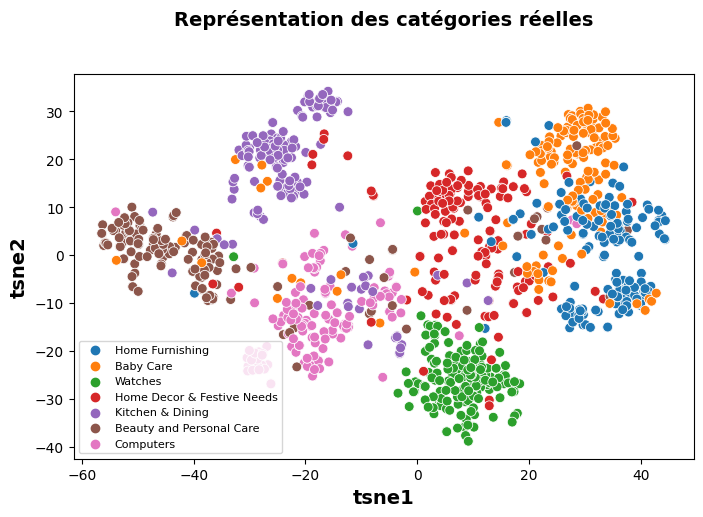

In [88]:
X_tsne = show_representation(feat_pca, data_little['cat'],
                             title="Représentation des catégories réelles")

Clustering en utilisant CNN

In [89]:
list_cat, list_col = compare_clustering(data_little['cat'], predict_CNN, True)
list_trad = [0]*len(list_cat)
for e in range(len(list_cat)):
    i = int(list_col[e][5:])
    list_trad[i] = list_cat[e]

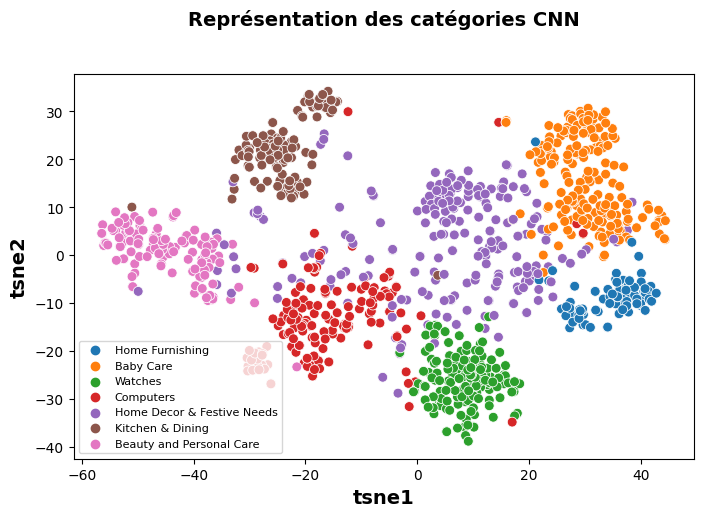

In [90]:
X_tsne = show_representation(feat_pca,
                             predict_CNN.apply(lambda e : list_trad[e]),
                             X_tsne=X_tsne,
                             title="Représentation des catégories CNN")

In [91]:
compare_clustering(data_little['cat'], predict_CNN)

ARI :  0.5716656646490383


Clustering avec ORB

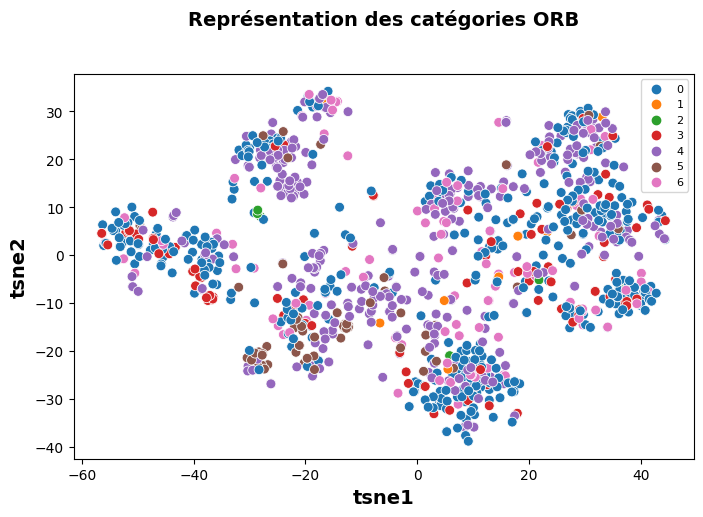

In [92]:
X_tsne = show_representation(feat_pca, predict_ORB, X_tsne=X_tsne, title="Représentation des catégories ORB")

In [93]:
compare_clustering(data_little['cat'], predict_ORB)

ARI :  0.02970296417628508


### Visualisation des données mal classées par le CNN de manière interactive

In [94]:
compare_clustering(data_little['cat'], predict_CNN)

ARI :  0.5716656646490383


In [95]:
list_cat, list_col = compare_clustering(data_little['cat'], predict_CNN, True)

In [96]:
tmp = data_little.copy()

In [97]:
tmp['label'] = tmp['cat'].apply(lambda e : list_cat.index(e))

In [98]:
tmp['pred'] = predict_CNN
tmp['pred'] = tmp['pred'].apply(lambda e : list_col.index('pred_'+str(e)))

In [99]:
@interact
def show_img(reel=list_cat, predit=list_cat, index=range(0, 10)):
    reel = list_cat.index(reel)
    predit = list_cat.index(predit)
    
    l = list(tmp.loc[(tmp['label']==reel) & (tmp['pred']==predit)].index)
    
    print("Nombre de lignes : ", len(l))
    if index >= len(l):
        return None

    print("Index de cette image dans tmp : ", l[index])
    
    return show_from_cv2(image_array[l[index]])

interactive(children=(Dropdown(description='reel', options=('Watches', 'Home Decor & Festive Needs', 'Computer…

# Conversion des images en plus petit (finalement non utilisé)

In [100]:
# Répertoire d'entrée contenant les images à redimensionner
input_dir = path_img

# Répertoire de sortie pour les images redimensionnées
output_dir = path_img_little

# Taille cible pour les images redimensionnées
target_size = (500, 500)

# Parcourir le répertoire d'entrée et redimensionner chaque image
for filename in []: # os.listdir(input_dir):
    # Vérifier que le fichier est une image
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Ouvrir l'image avec PIL
        image_path = os.path.join(input_dir, filename)
        image = Image.open(image_path)
        # Redimensionner l'image avec la méthode thumbnail de PIL
        image.thumbnail(target_size)
        # Enregistrer l'image redimensionnée dans le répertoire de sortie
        output_path = os.path.join(output_dir, filename)
        image.save(output_path)